# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [33]:
%%html
<audio src="https://oobabooga.github.io/silence.m4a" controls>

In [1]:
%%capture
!pip install torchmetrics

In [2]:
!nvidia-smi

Tue May 30 06:32:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [35]:
from torchvision import datasets
from torchsummary import summary
from torchmetrics import Accuracy, ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import matplotlib as mpl
import seaborn as sb
import mlxtend
import gc
import fastai

sb.set_theme()
mpl.rcParams['image.cmap'] = 'gray'
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
torch.manual_seed(17)
torch.cuda.manual_seed(17)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
torch.cuda.get_device_name()

'Tesla T4'

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [47]:
# Define transforms
## YOUR CODE HERE ##
train_transforms = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(0.25)])
test_transforms = train_transforms = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])
# Create training set and define training dataloader
## YOUR CODE HERE ##
training_set = datasets.MNIST(root='data', train=True, download=True, transform=train_transforms)
train_loader = DataLoader(training_set, batch_size=60000, shuffle=True)
# Create test set and define test dataloader
## YOUR CODE HERE ##
testing_set = datasets.MNIST(root='data', train=False, download=True, transform=test_transforms)
test_loader = DataLoader(testing_set, batch_size=10000, shuffle=False)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

The transformations were inspired by the LeNet 5 paper ([LeCunn et al. 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)), where LeCunn et al. reported that training with augmentation via planar affine transformation improved testing accuracy, and medium distortions worked better than huge distortions. The rotation and horizontal flip were taken from as they also preserve the general patterns (e.g., parallel lines) of data while making examples seem different. The normalization parameters were taken from PyTorch's [MNIST example](https://github.com/pytorch/examples/blob/main/mnist/main.py#L120). For testing, we only need to normalize the data, since we don't want to augment the test set.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [50]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

4


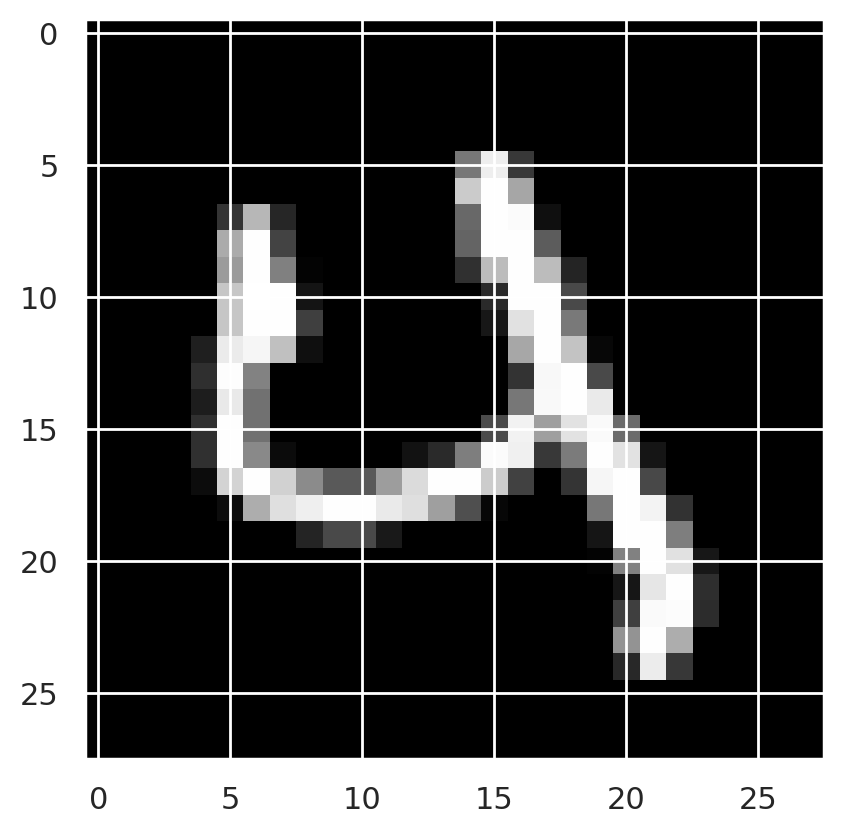

5


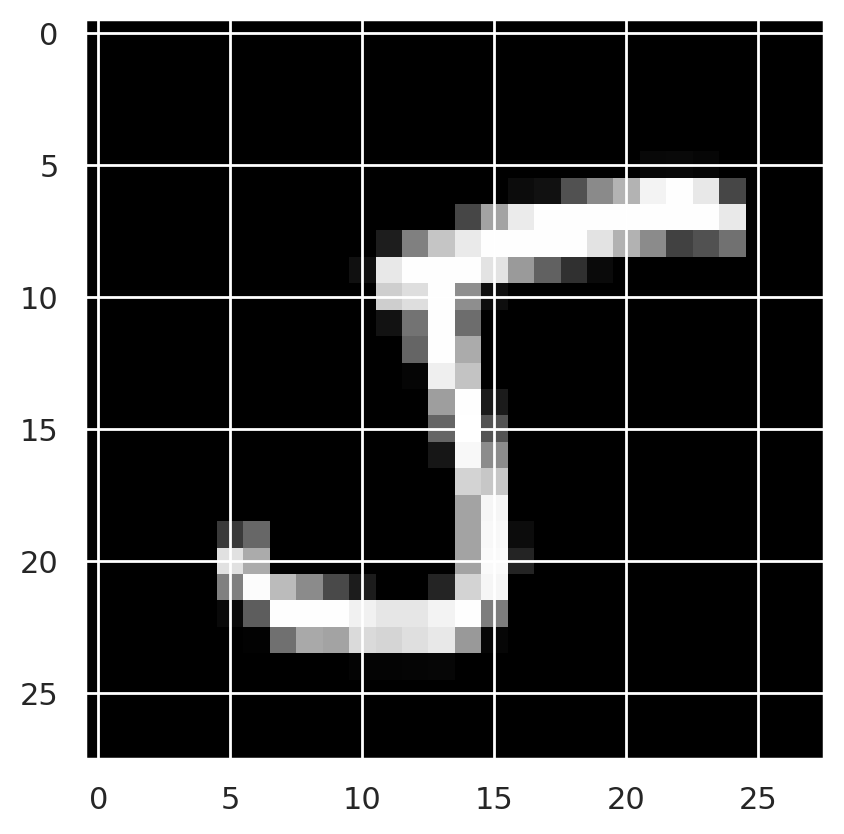

1


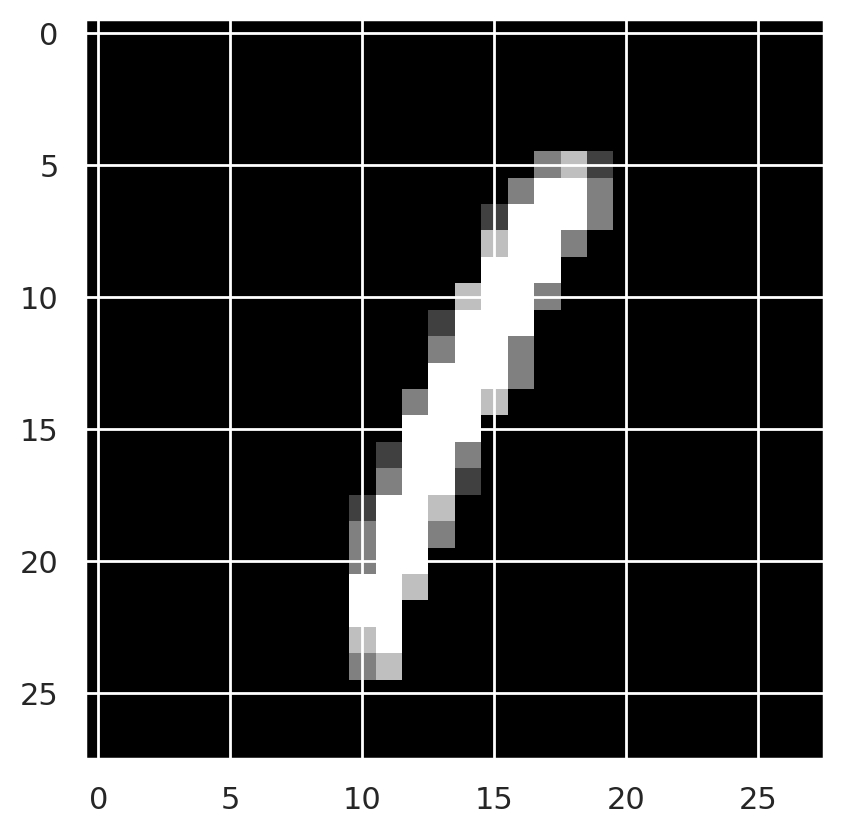

4


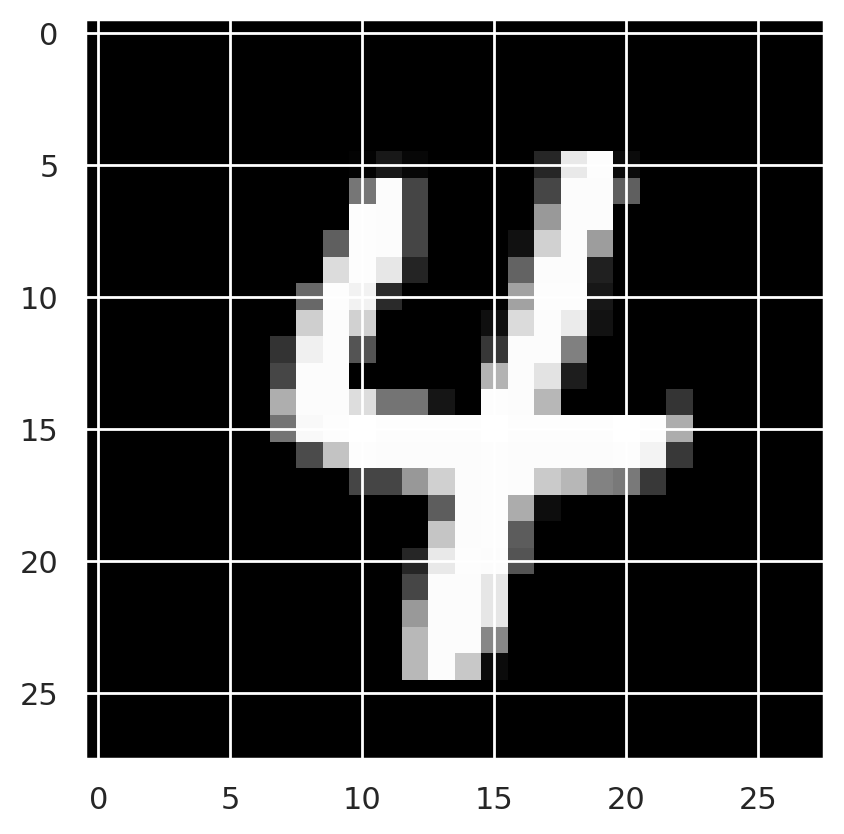

4


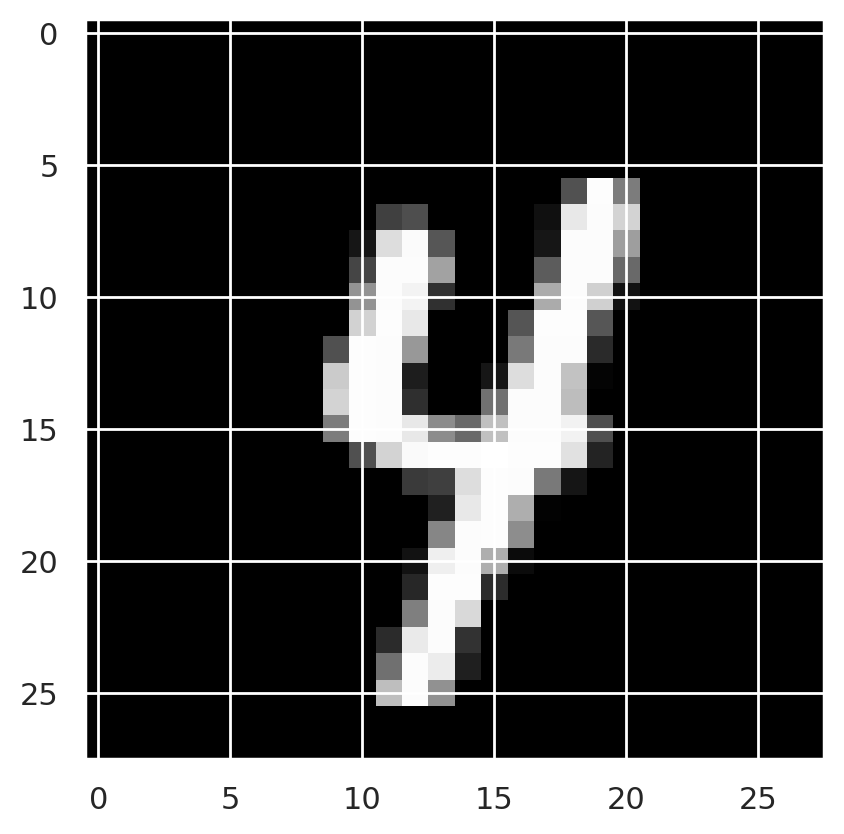

In [51]:
# Explore train data
show5(train_loader) # Some are already distored

7


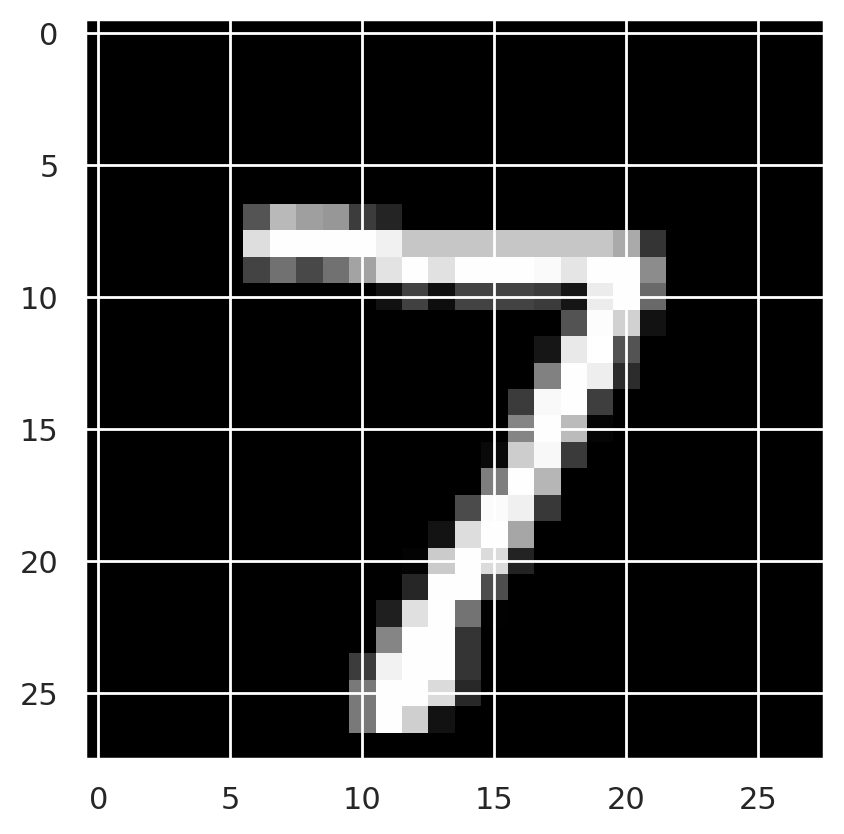

2


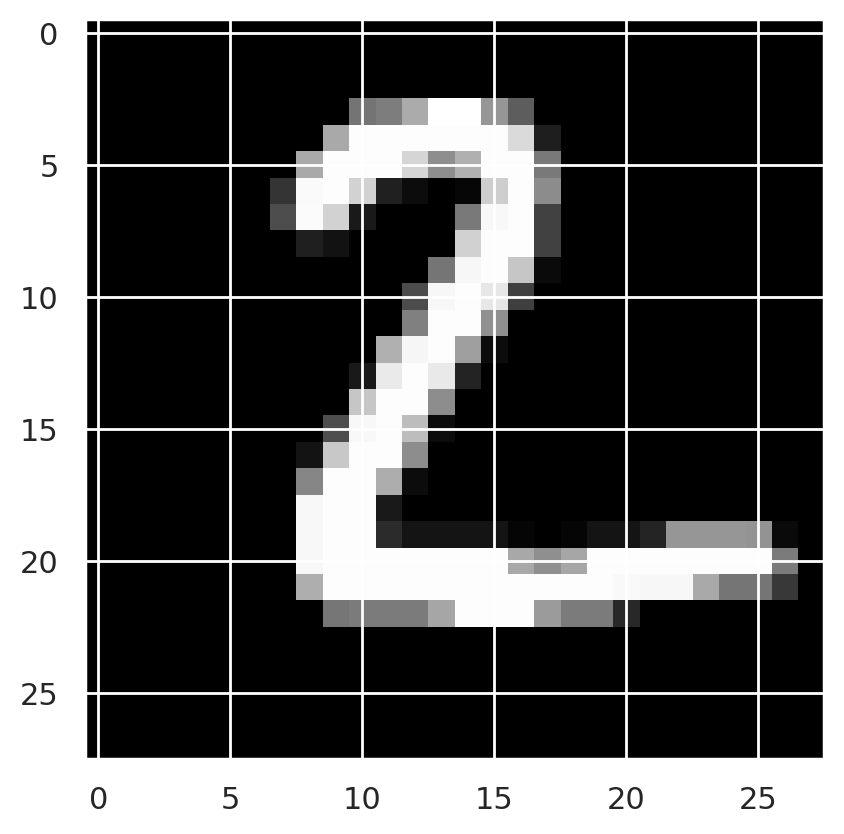

1


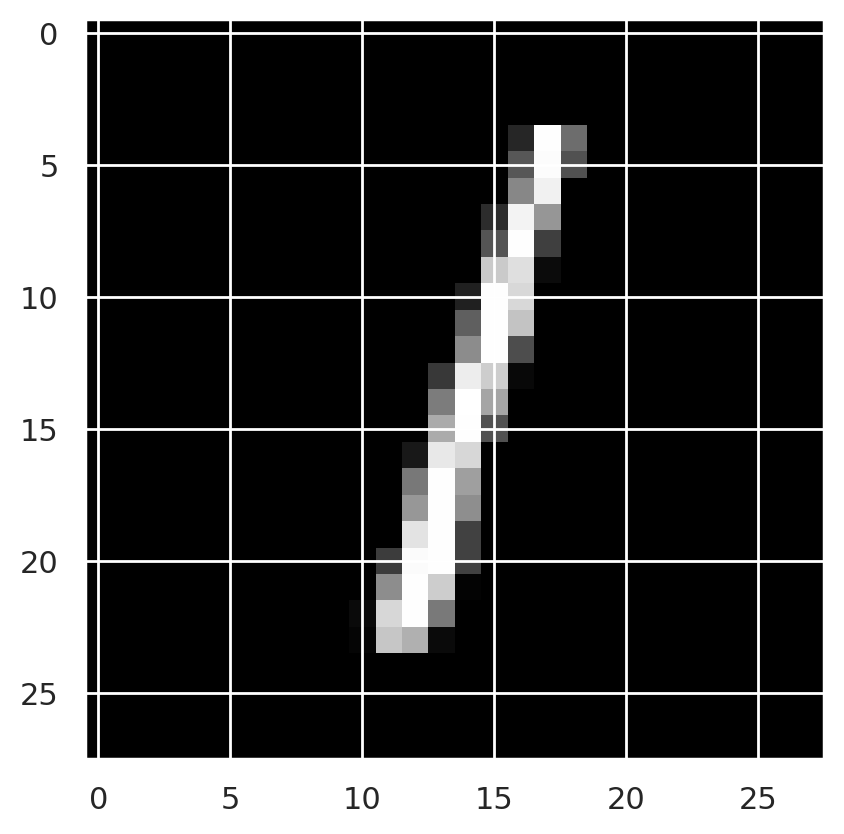

0


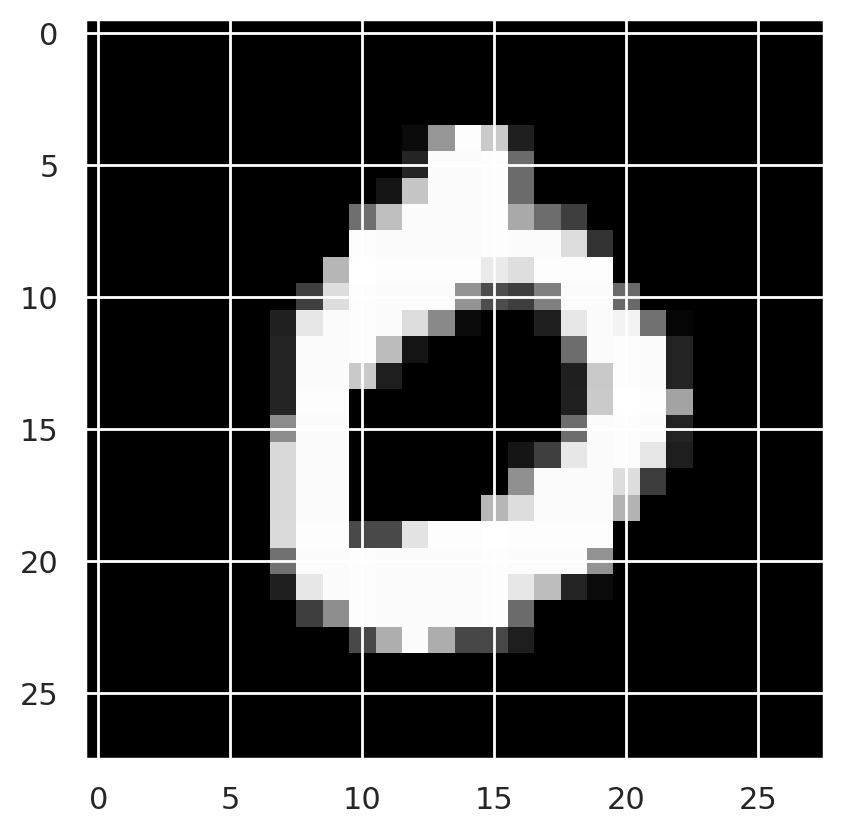

4


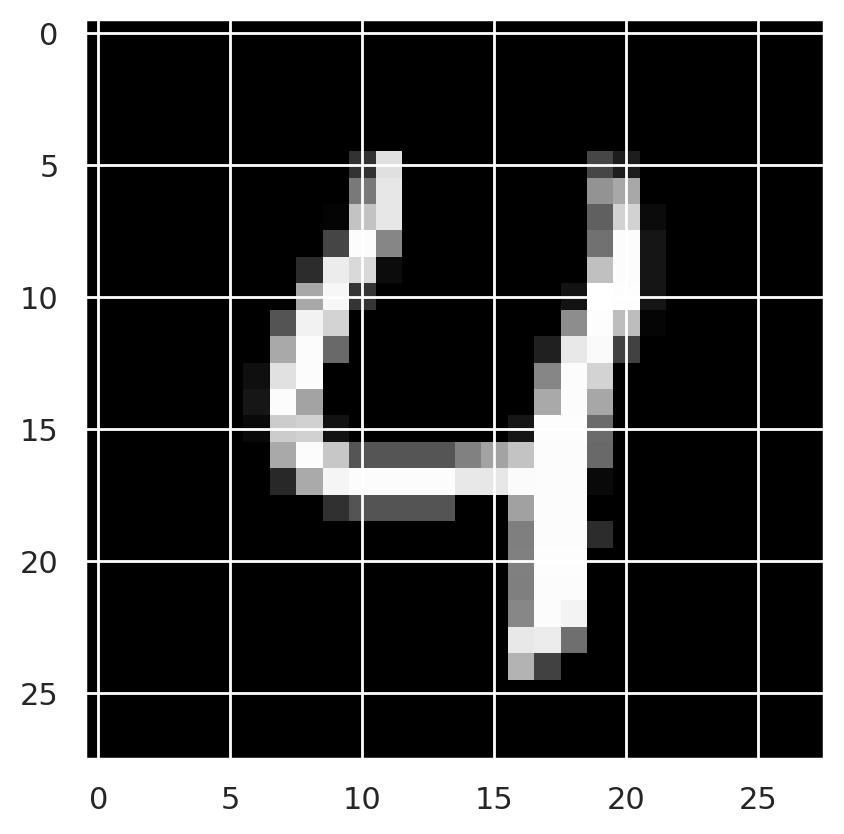

In [52]:
# Explore test data
show5(test_loader)

In [11]:
print("Training set shape: ", training_set.data.size())
print("Test set shape: ", testing_set.data.size())

Training set shape:  torch.Size([60000, 28, 28])
Test set shape:  torch.Size([10000, 28, 28])


The input is a $28\times 28$ image, a bit different from the original $32\times 32$ image reported in the paper.

In [12]:
train_features = training_set.data.view(-1, 28*28).numpy()
train_labels = training_set.targets.numpy()

test_features = testing_set.data.view(-1, 28*28).numpy()
test_labels = testing_set.targets.numpy()

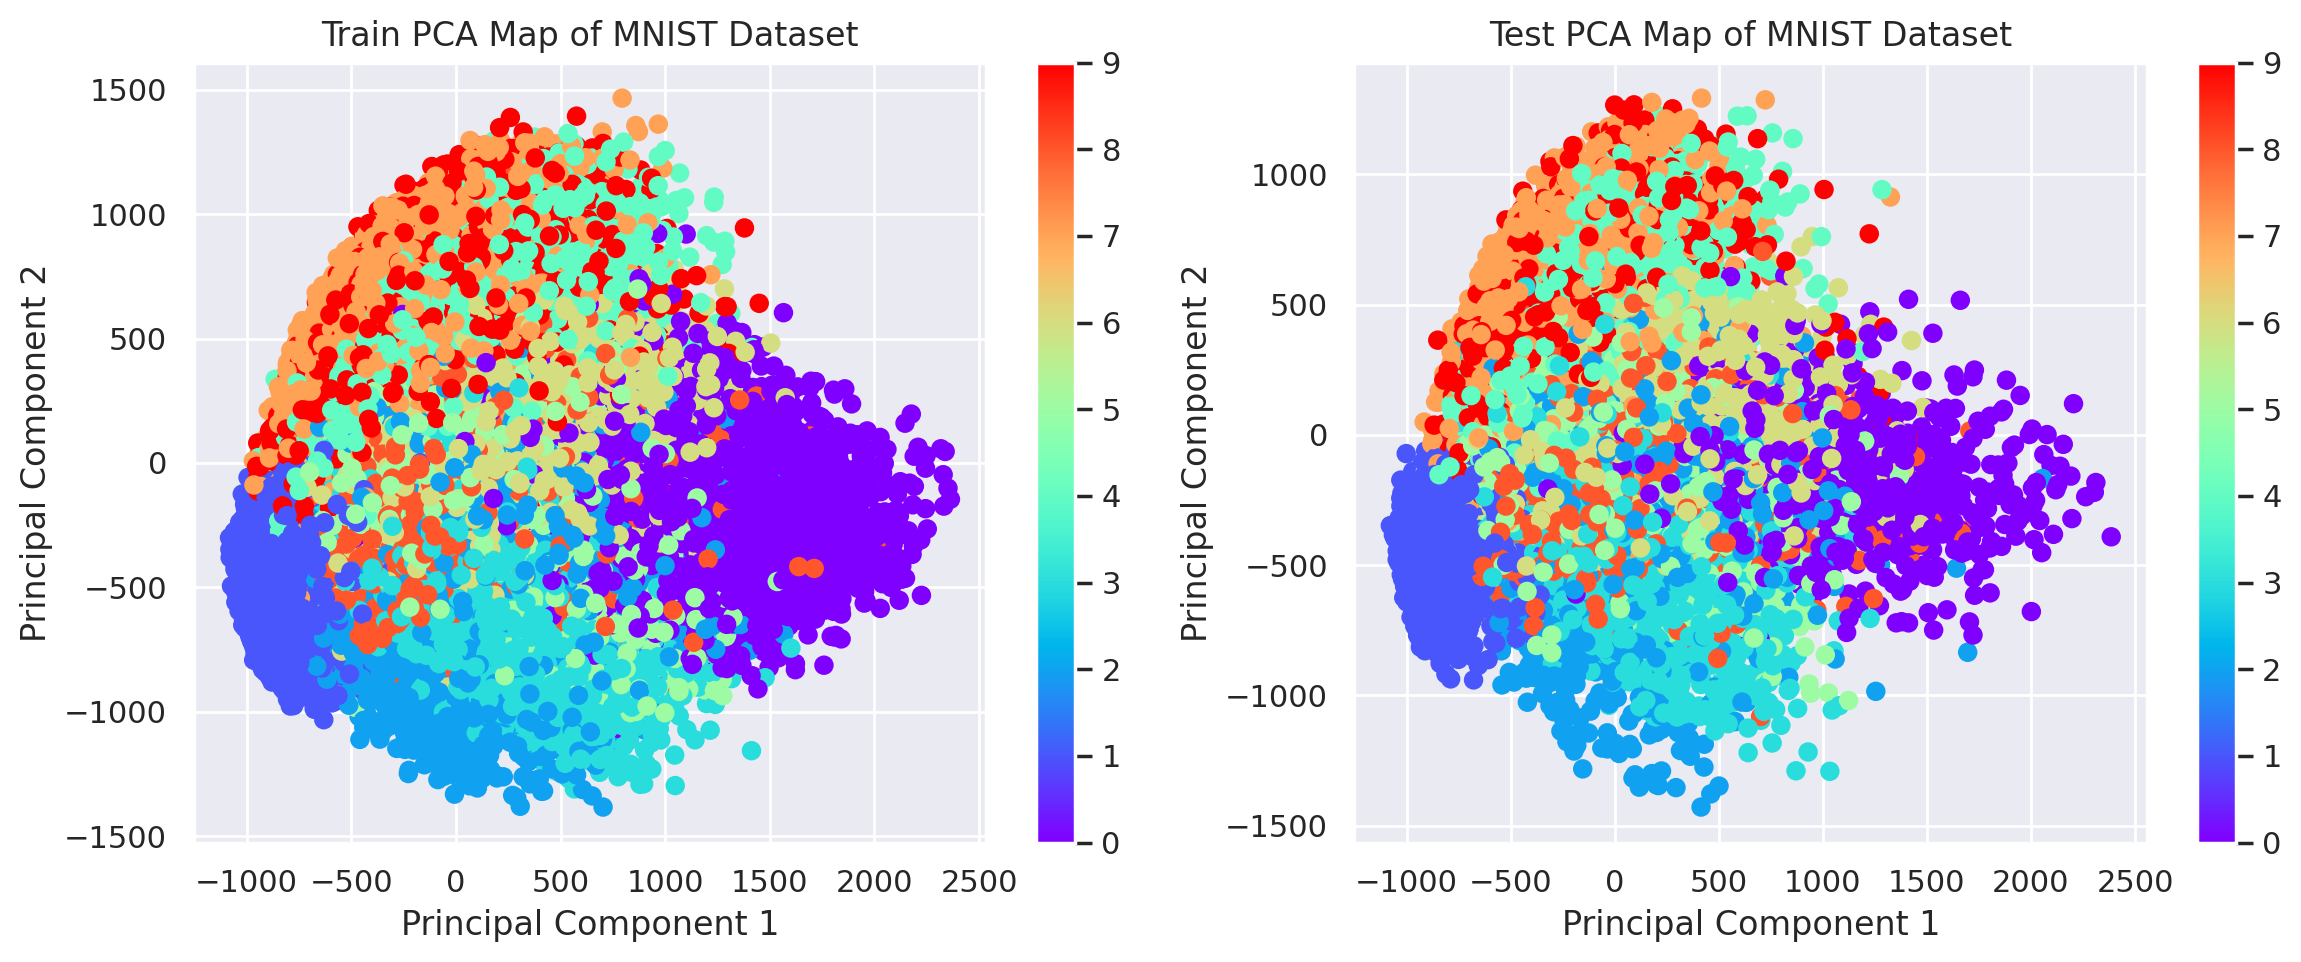

In [13]:
# Perform and plot PCA on the train and test dataset
pca = PCA(n_components=2)
train_pca_features = pca.fit_transform(train_features)
test_pca_features = pca.transform(test_features)

# Plot the PCA maps side by side
plt.figure(figsize=(12, 5))

# Plot train PCA map
plt.subplot(1, 2, 1)
plt.scatter(train_pca_features[:, 0], train_pca_features[:, 1], c=train_labels, cmap='rainbow')
plt.colorbar()
plt.title("Train PCA Map of MNIST Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Plot test PCA map
plt.subplot(1, 2, 2)
plt.scatter(test_pca_features[:, 0], test_pca_features[:, 1], c=test_labels, cmap='rainbow')
plt.colorbar()
plt.title("Test PCA Map of MNIST Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.tight_layout()
plt.show()

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [14]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolutional_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=1, stride=1),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.LayerNorm([14,14]),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.LayerNorm([5,5]),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.GELU()
        )
        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.GELU(),
            nn.LayerNorm(84),
            nn.Linear(in_features=84, out_features=10),
        )
    
    def forward(self, x):
        x = self.convolutional_layer(x)
        x = torch.flatten(x, 1)
        x = self.linear_layer(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [39]:
model = LeNet5().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              12
              GELU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
         LayerNorm-4            [-1, 6, 14, 14]             392
            Conv2d-5           [-1, 16, 10, 10]           2,416
              GELU-6           [-1, 16, 10, 10]               0
         MaxPool2d-7             [-1, 16, 5, 5]               0
         LayerNorm-8             [-1, 16, 5, 5]              50
            Conv2d-9            [-1, 120, 1, 1]          48,120
             GELU-10            [-1, 120, 1, 1]               0
           Linear-11                   [-1, 84]          10,164
             GELU-12                   [-1, 84]               0
        LayerNorm-13                   [-1, 84]             168
           Linear-14                   

In [40]:
accuracy_fn = Accuracy(task='multiclass', num_classes=10).to(device)

In [41]:
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [69]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.001, total_steps=30, )

In [90]:
gc.collect()
torch.cuda.empty_cache()

In [70]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module,
               device, 
               accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for images, labels in tqdm(data_loader, total=len(data_loader)):
            images, labels = images.to(device), labels.to(device)
            # Make predictions with the model
            preds = model(images)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(preds, labels)
            acc += accuracy_fn(preds.argmax(dim=1), labels)
            gc.collect()
            torch.cuda.empty_cache()
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model results on test dataset
model_results = eval_model(model=model,
                           data_loader=test_loader,
                           loss_fn=criterion,
                           device=device,
                           accuracy_fn=accuracy_fn)
model_results

  0%|          | 0/1 [00:00<?, ?it/s]

{'model_name': 'LeNet5',
 'model_loss': 0.5914297103881836,
 'model_acc': tensor(0.8789, device='cuda:0')}

The first accuracy is approximately 0.10, expected of an untrained model.

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [71]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler.LRScheduler,
               accuracy_fn=accuracy_fn,
               device=device):
    train_loss, train_acc = 0, 0
    model.train()
    # Model is expected to be in GPU already
    for batch, (images, labels) in tqdm(enumerate(data_loader),
                                        total=len(data_loader),
                                        desc='Training model:'):
        images, labels= images.to(device), labels.to(device)

        # 1. Forward pass
        preds = model(images)

        # 2. Calculate loss
        loss = loss_fn(preds, labels)
        train_loss += loss
        train_acc += accuracy_fn(preds.argmax(dim=1), labels)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # 6. Garbage collection on GPU RAM
        gc.collect()
        torch.cuda.empty_cache()
    scheduler.step()
    # Exponential learning rate scheduler reduces learning rate too fast
    # A better option is torch.optim.lr_scheduler.OneCycleLR from the paper
    # of https://arxiv.org/pdf/1708.07120.pdf on MNIST dataset
    # I changed from exponential learning rate to onecycle learning scheduler
    # as performance became slow after 70 epochs.

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}")
    return train_loss.cpu(), train_acc.cpu()

def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn=accuracy_fn,
               device=device):
    test_loss, test_acc = 0, 0
    model.eval() 
    # Turn on inference context manager
    with torch.inference_mode(): 
        for images, labels in tqdm(data_loader,
                                    total=len(data_loader),
                                    desc='Making predictions:'):
            
            images, labels= images.to(device), labels.to(device)
            
            # 1. Forward pass
            preds = model(images)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(preds, labels)
            test_acc += accuracy_fn(preds.argmax(dim=1), labels)

            gc.collect()
            torch.cuda.empty_cache()

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}")
    return test_loss.cpu(), test_acc.cpu()

In [56]:
epochs = 30
train_losses = [] 
test_losses = []
train_accuracies = []
test_accuracies = []

In [72]:
tolerance = 0
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_loader, criterion, optimizer, scheduler)
    test_loss, test_acc = test_step(model, test_loader, criterion)
    train_losses.append(train_loss), train_accuracies.append(train_acc)
    test_losses.append(test_loss), test_accuracies.append(test_acc)
    if len(test_losses) > 1 and float(test_losses[-2] - test_losses[-1]) < 1e-4:
        tolerance += 1
        if tolerance > 2:
            break
        

  0%|          | 0/30 [00:00<?, ?it/s]

Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.60754 | Train accuracy: 0.87


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.58896 | Test accuracy: 0.88


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.60503 | Train accuracy: 0.87


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.58428 | Test accuracy: 0.88


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.60029 | Train accuracy: 0.87


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.57353 | Test accuracy: 0.88


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.58937 | Train accuracy: 0.88


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.55429 | Test accuracy: 0.89


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.56982 | Train accuracy: 0.88


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.52642 | Test accuracy: 0.89


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.54148 | Train accuracy: 0.89


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.49222 | Test accuracy: 0.90


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.50668 | Train accuracy: 0.89


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.45552 | Test accuracy: 0.90


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.46936 | Train accuracy: 0.90


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.42009 | Test accuracy: 0.91


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.43339 | Train accuracy: 0.91


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.38860 | Test accuracy: 0.92


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.40143 | Train accuracy: 0.91


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.36155 | Test accuracy: 0.92


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.37386 | Train accuracy: 0.92


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.33826 | Test accuracy: 0.93


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.34994 | Train accuracy: 0.92


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.31823 | Test accuracy: 0.93


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.32919 | Train accuracy: 0.93


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.30103 | Test accuracy: 0.93


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.31127 | Train accuracy: 0.93


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.28634 | Test accuracy: 0.93


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.29588 | Train accuracy: 0.93


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.27381 | Test accuracy: 0.94


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.28273 | Train accuracy: 0.93


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.26316 | Test accuracy: 0.94


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.27154 | Train accuracy: 0.94


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.25415 | Test accuracy: 0.94


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.26206 | Train accuracy: 0.94


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.24657 | Test accuracy: 0.94


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.25410 | Train accuracy: 0.94


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.24024 | Test accuracy: 0.94


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.24746 | Train accuracy: 0.94


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.23504 | Test accuracy: 0.94


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.24199 | Train accuracy: 0.94


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.23083 | Test accuracy: 0.94


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.23757 | Train accuracy: 0.94


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.22750 | Test accuracy: 0.95


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.23407 | Train accuracy: 0.94


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.22493 | Test accuracy: 0.95


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.23139 | Train accuracy: 0.95


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.22304 | Test accuracy: 0.95


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.22940 | Train accuracy: 0.95


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.22172 | Test accuracy: 0.95


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.22801 | Train accuracy: 0.95


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.22086 | Test accuracy: 0.95


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.22711 | Train accuracy: 0.95


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.22038 | Test accuracy: 0.95


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.22660 | Train accuracy: 0.95


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.22016 | Test accuracy: 0.95


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.22638 | Train accuracy: 0.95


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.22011 | Test accuracy: 0.95


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.22632 | Train accuracy: 0.95


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.22011 | Test accuracy: 0.95


Plot the training loss (and validation loss/accuracy, if recorded).

In [58]:
train_losses[0]

tensor(2.5365, grad_fn=<ToCopyBackward0>)

In [73]:
train_losses = [x.detach() for x in train_losses] 
test_losses = [x.detach() for x in test_losses]
train_accuracies = [x.cpu() for x in train_accuracies]
test_accuracies = [x.cpu() for x in train_accuracies]
train_losses[0]

tensor(2.5365)

In [79]:
test_accuracies[0]

tensor(0.0713)

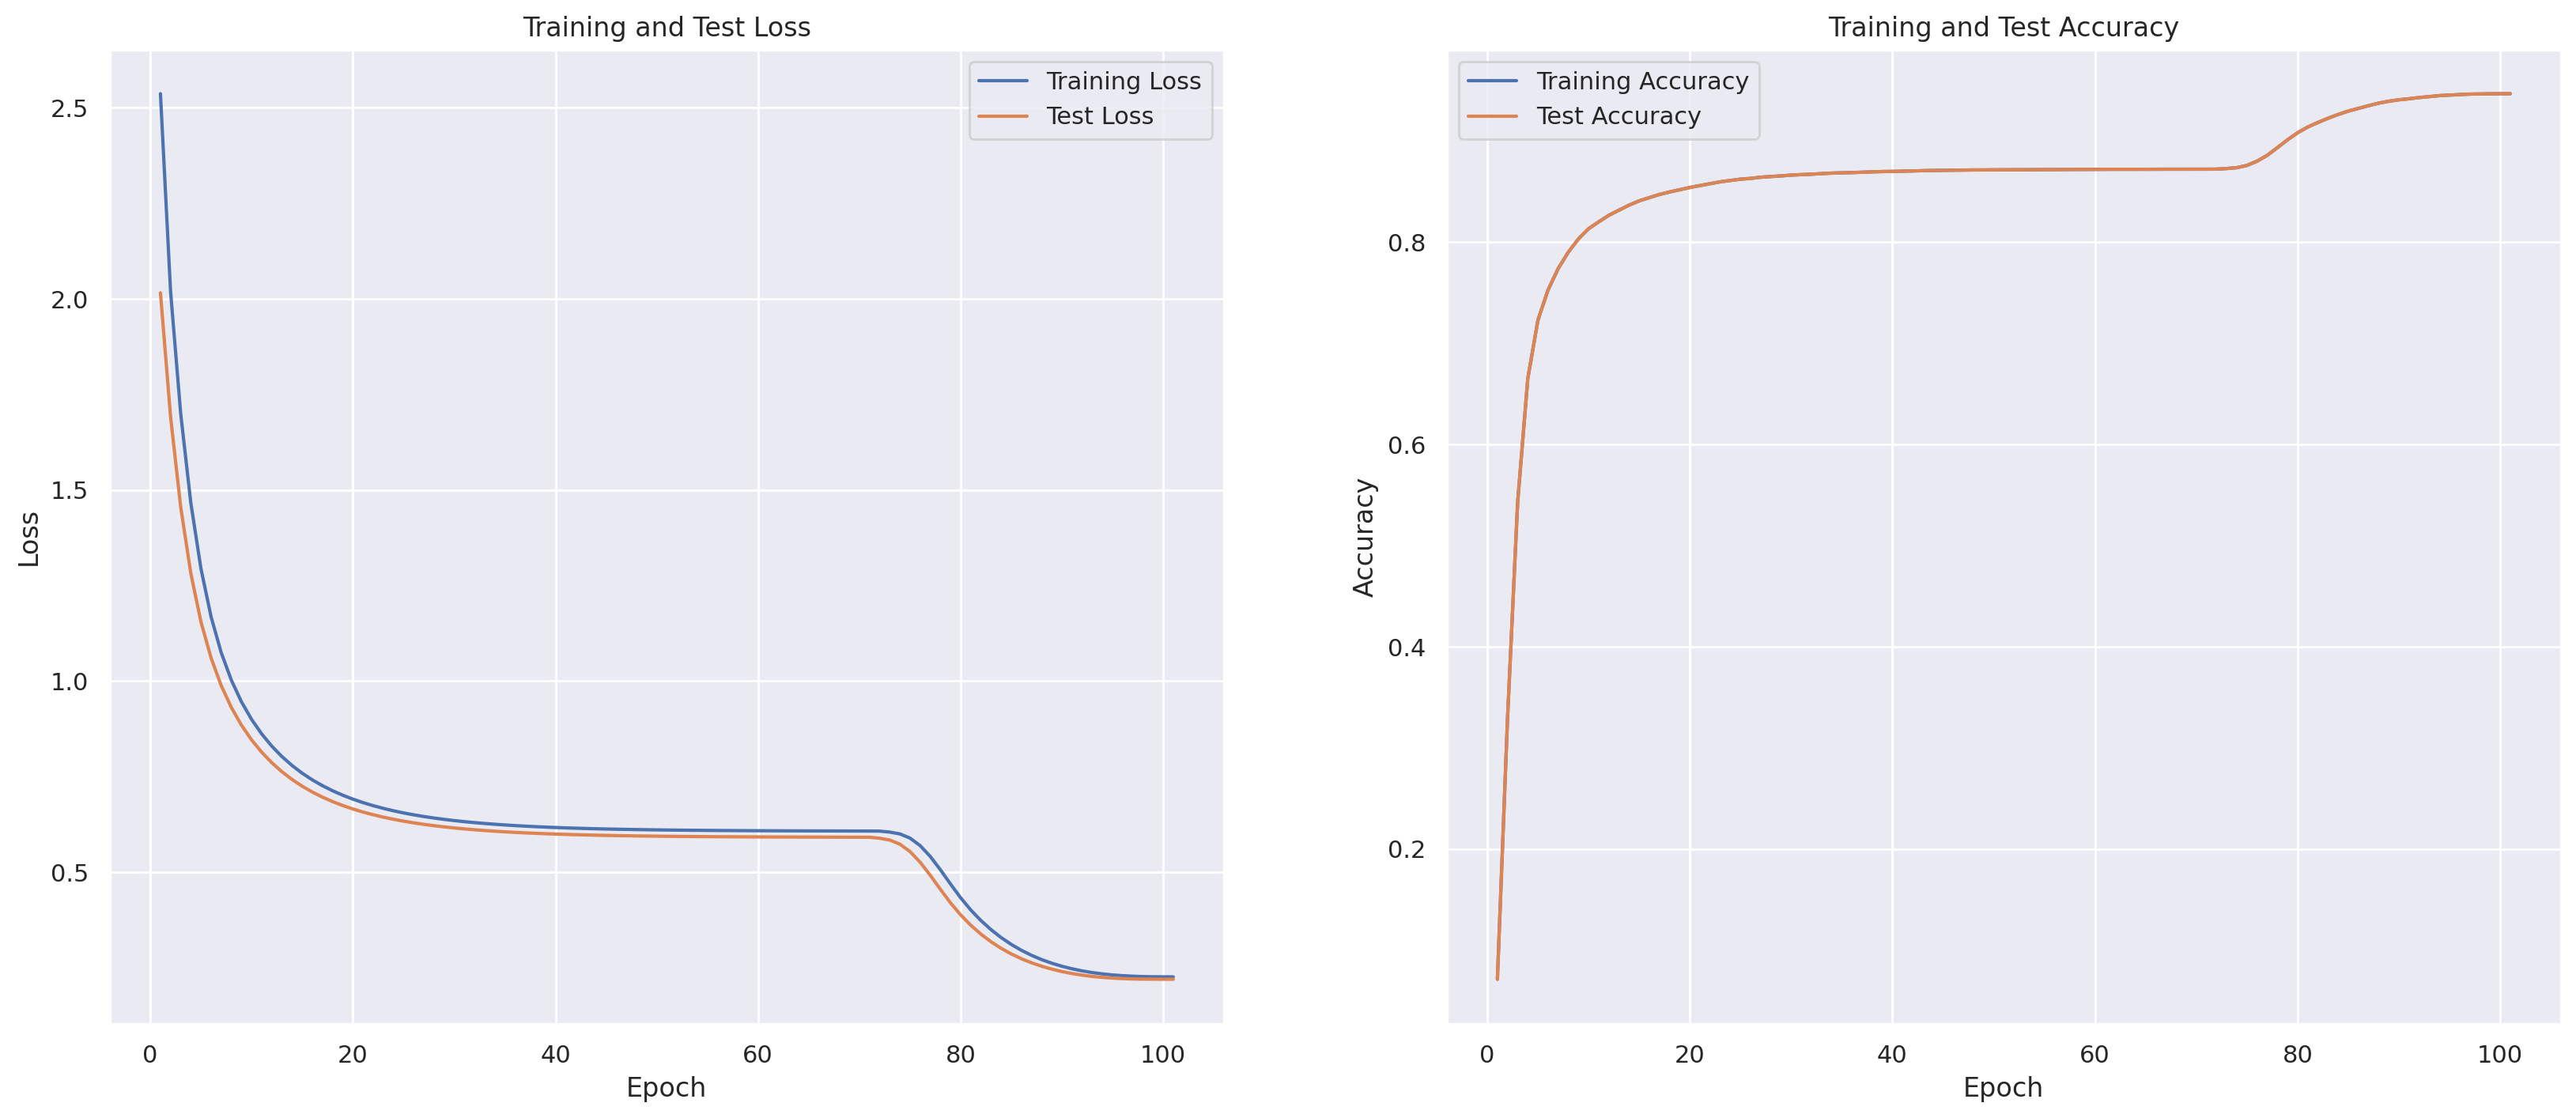

In [77]:
num_epochs = len(train_losses)
epochs = range(1, num_epochs + 1)

# Plot subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot loss subplot
ax1.plot(epochs, train_losses, label='Training Loss')
ax1.plot(epochs, test_losses, label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()

# Plot accuracy subplot
ax2.plot(epochs, train_accuracies, label='Training Accuracy')
ax2.plot(epochs, test_accuracies, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Test Accuracy')
ax2.legend()

# Show the plot
plt.show()

If training is continued, the model may achieve the accuracy that it should have based on the LeNet-5 paper: $99.1$-$99.2$%.

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [80]:
def prediction_step(model: torch.nn.Module,
                    data_loader: torch.utils.data.DataLoader,
                    accuracy_fn=accuracy_fn,
                    device=device):
    test_acc = 0
    model.eval()
    pred_probs = []
    # Turn on inference context manager
    with torch.inference_mode(): 
        for images, labels in tqdm(data_loader,
                                    total=len(data_loader),
                                    desc='Making predictions:'):
            
            images, labels= images.to(device), labels.to(device)
            
            # 1. Forward pass
            preds = model(images)
            
            # 2. Calculate prediction probability and accuracy
            pred_probs.append(torch.softmax(preds.squeeze(), dim=0).cpu())
            test_acc += accuracy_fn(preds.argmax(dim=1), labels)

            gc.collect()
            torch.cuda.empty_cache()

        # Adjust metrics and print out
        test_acc /= len(data_loader)
    return torch.stack(pred_probs), test_acc.cpu()

In [82]:
final_test_probability, final_test_accuracy = prediction_step(model, test_loader)

Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
print(f'Final test accuracy: {final_test_accuracy*100:.2f}%')
print('Example probability output: ', final_test_probability[0][0])
print('Example class output: ', final_test_probability[0][0].argmax(dim=0))

In [89]:
print(f'Final test accuracy: {final_test_accuracy*100:.2f}%')
print('Example probability output: ', final_test_probability[0][0])
print('Example class output: ', final_test_probability[0][0].argmax(dim=0))

Final test accuracy: 94.77%
Example probability output:  tensor([2.5922e-06, 2.6402e-06, 1.2357e-05, 1.2332e-05, 1.3525e-06, 1.1708e-05,
        7.2263e-06, 1.1025e-03, 4.2130e-06, 1.6140e-05])
Example class output:  tensor(7)


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [106]:
model_1 = LeNet5().to(device)
summary(model_1, input_size=(1, 28, 28))
optimizer_1 = optim.AdamW(model_1.parameters(), lr=0.001, weight_decay=5e-4)
scheduler_1 = torch.optim.lr_scheduler.OneCycleLR(optimizer_1, 0.01, total_steps=25)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              12
              GELU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
         LayerNorm-4            [-1, 6, 14, 14]             392
            Conv2d-5           [-1, 16, 10, 10]           2,416
              GELU-6           [-1, 16, 10, 10]               0
         MaxPool2d-7             [-1, 16, 5, 5]               0
         LayerNorm-8             [-1, 16, 5, 5]              50
            Conv2d-9            [-1, 120, 1, 1]          48,120
             GELU-10            [-1, 120, 1, 1]               0
           Linear-11                   [-1, 84]          10,164
             GELU-12                   [-1, 84]               0
        LayerNorm-13                   [-1, 84]             168
           Linear-14                   

In [107]:
epochs = 25
train_losses_1 = [] 
test_losses_1 = []
train_accuracies_1 = []
test_accuracies_1 = []
tolerance = 0

In [108]:
for epoch in tqdm(range(epochs)):
    train_loss_1, train_acc_1 = train_step(model_1, train_loader, criterion, optimizer_1, scheduler_1)
    test_loss_1, test_acc_1 = test_step(model_1, test_loader, criterion)
    train_losses_1.append(train_loss_1), train_accuracies_1.append(train_acc_1)
    test_losses_1.append(test_loss_1), test_accuracies_1.append(test_acc_1)
    if len(test_losses_1) > 1 and float(test_losses_1[-2] - test_losses_1[-1]) < 1e-4:
        tolerance += 1
        if tolerance > 2:
            break

  0%|          | 0/25 [00:00<?, ?it/s]

Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 2.44373 | Train accuracy: 0.09


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 2.19995 | Test accuracy: 0.21


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 2.20822 | Train accuracy: 0.21


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 1.79925 | Test accuracy: 0.48


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 1.81451 | Train accuracy: 0.47


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 1.33386 | Test accuracy: 0.66


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 1.34814 | Train accuracy: 0.65


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.97134 | Test accuracy: 0.79


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.97992 | Train accuracy: 0.78


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.75559 | Test accuracy: 0.81


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.76598 | Train accuracy: 0.81


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.66063 | Test accuracy: 0.80


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.67043 | Train accuracy: 0.80


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.55119 | Test accuracy: 0.82


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.57272 | Train accuracy: 0.82


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.42083 | Test accuracy: 0.89


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.44078 | Train accuracy: 0.88


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.36443 | Test accuracy: 0.90


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.37988 | Train accuracy: 0.89


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.30867 | Test accuracy: 0.91


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.32252 | Train accuracy: 0.91


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.27030 | Test accuracy: 0.92


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.28510 | Train accuracy: 0.92


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.24058 | Test accuracy: 0.93


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.25652 | Train accuracy: 0.92


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.21515 | Test accuracy: 0.94


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.23161 | Train accuracy: 0.93


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.19811 | Test accuracy: 0.94


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.21373 | Train accuracy: 0.94


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.18554 | Test accuracy: 0.95


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.19967 | Train accuracy: 0.94


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.17528 | Test accuracy: 0.95


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.18818 | Train accuracy: 0.94


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.16662 | Test accuracy: 0.95


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.17902 | Train accuracy: 0.95


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.15956 | Test accuracy: 0.95


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.17186 | Train accuracy: 0.95


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.15394 | Test accuracy: 0.96


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.16623 | Train accuracy: 0.95


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.14969 | Test accuracy: 0.96


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.16196 | Train accuracy: 0.95


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.14676 | Test accuracy: 0.96


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.15900 | Train accuracy: 0.95


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.14501 | Test accuracy: 0.96


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.15720 | Train accuracy: 0.95


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.14419 | Test accuracy: 0.96


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.15635 | Train accuracy: 0.95


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.14397 | Test accuracy: 0.96


Training model::   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.15612 | Train accuracy: 0.95


Making predictions::   0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.14397 | Test accuracy: 0.96


In [110]:
train_losses_1 = [x.detach() for x in train_losses_1] 
test_losses_1 = [x.detach() for x in test_losses_1]
train_accuracies_1 = [x.cpu() for x in train_accuracies_1]
test_accuracies_1 = [x.cpu() for x in train_accuracies_1]

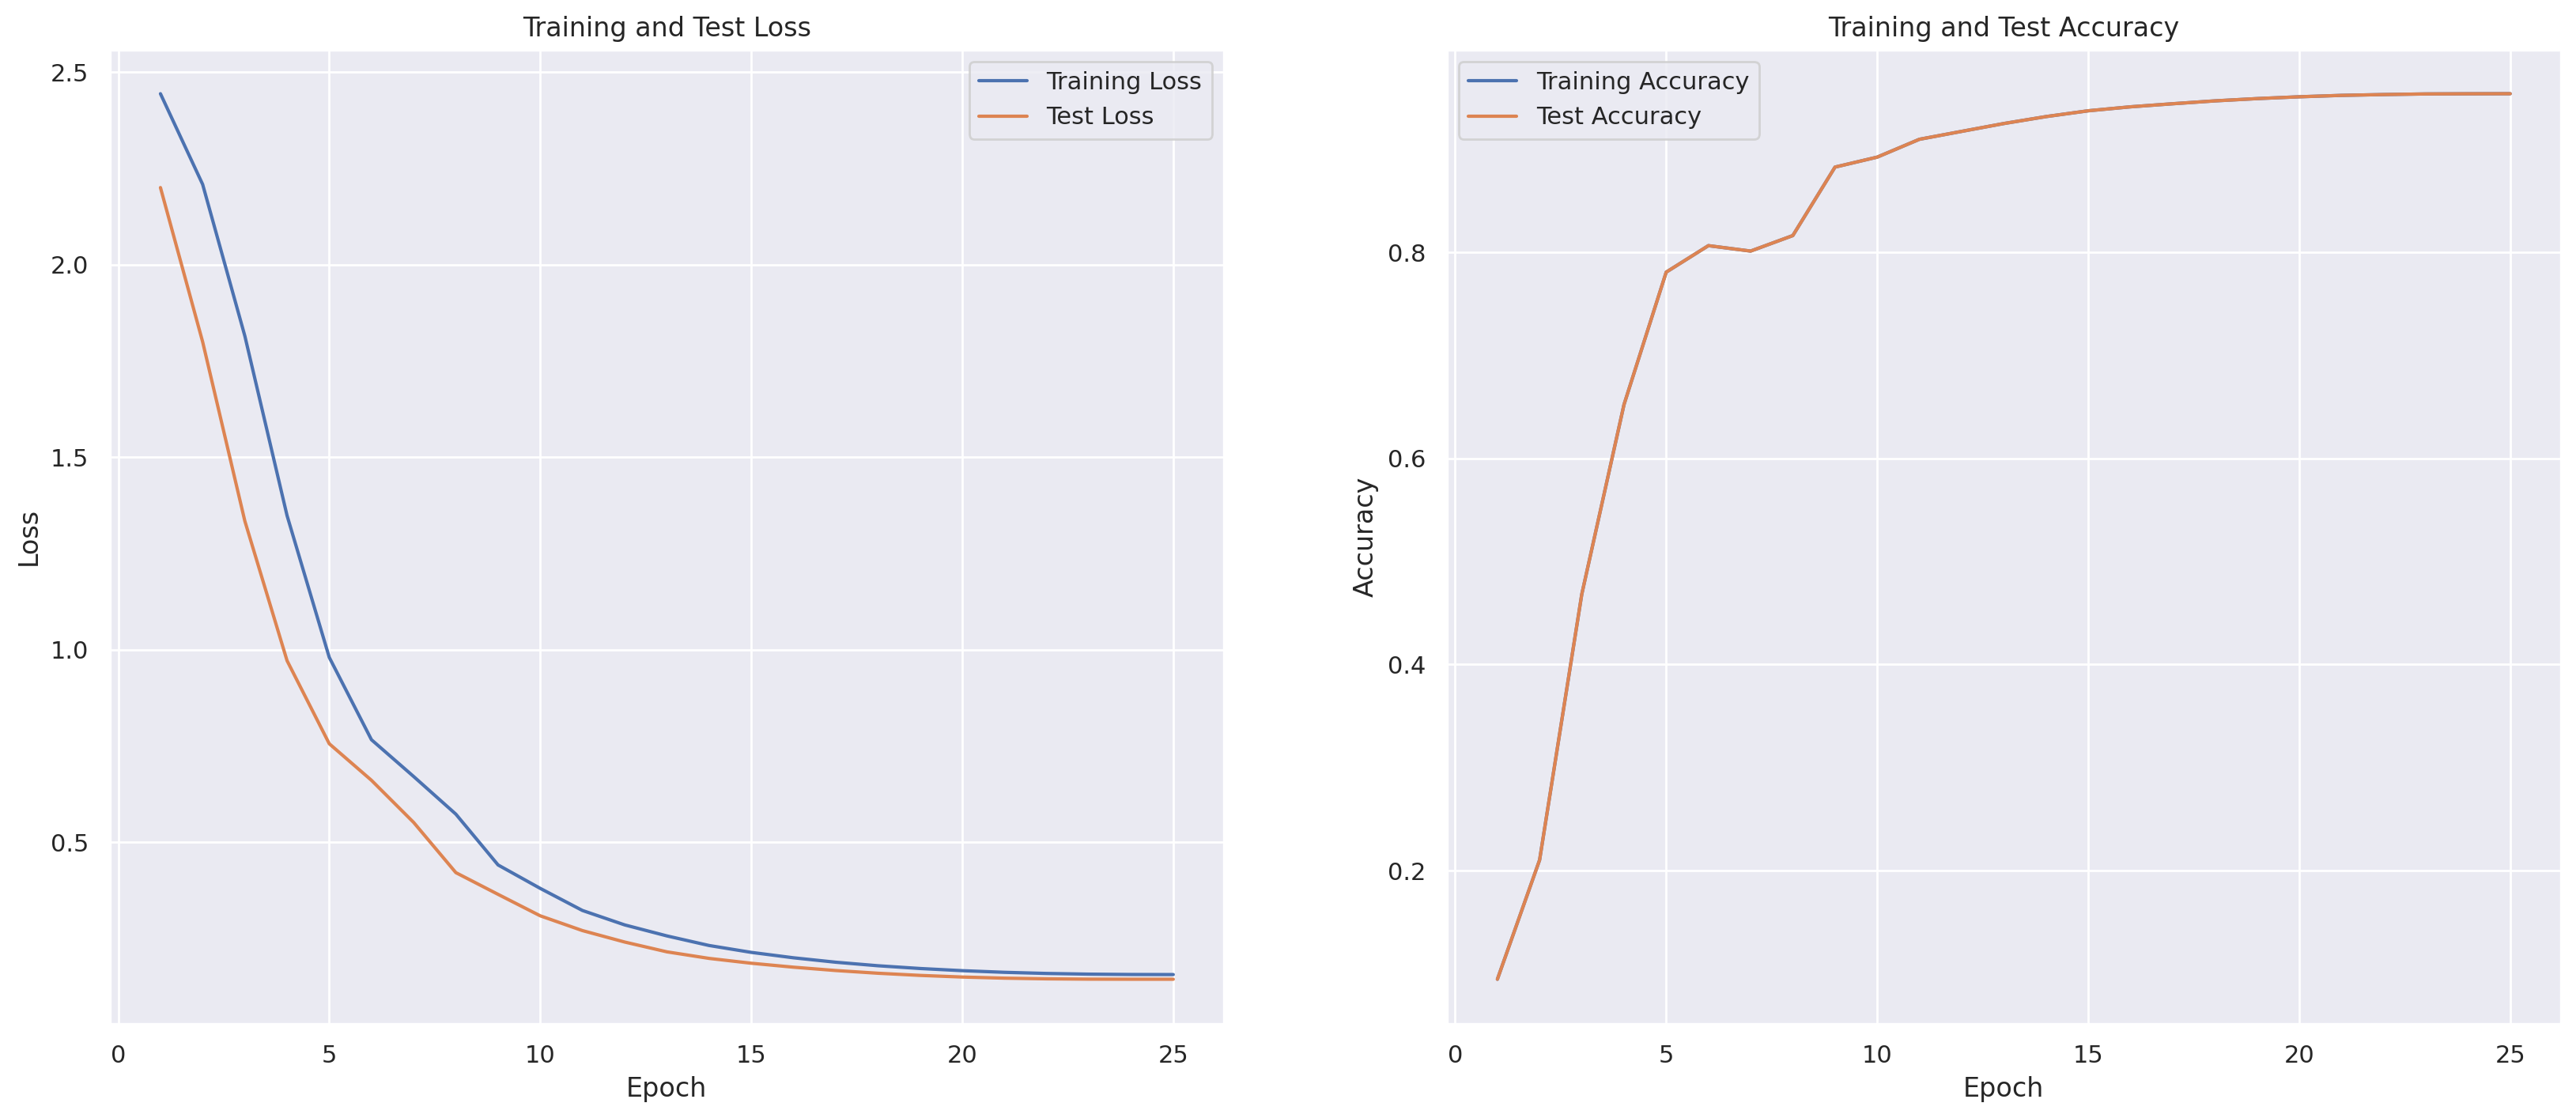

In [111]:
num_epochs = len(train_losses_1)
epochs = range(1, num_epochs + 1)

# Plot subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot loss subplot
ax1.plot(epochs, train_losses_1, label='Training Loss')
ax1.plot(epochs, test_losses_1, label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()

# Plot accuracy subplot
ax2.plot(epochs, train_accuracies_1, label='Training Accuracy')
ax2.plot(epochs, test_accuracies_1, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Test Accuracy')
ax2.legend()

# Show the plot
plt.show()

By tweaking the parameters, the model achieves higher accuracy with 1/4 the time required. It must be noted that the learning rate and maximum learning rate for `optimizer` and `scheduler` can be set one magnitude higher to receive an accuracy > 0.99 (according to [Super-Convergence](https://arxiv.org/pdf/1708.07120.pdf) paper).

## Saving your model
Using `torch.save`, save your model for future loading.

In [92]:
torch.save(model, 'model.pt')

In [112]:
torch.save(model_1, 'model_1.pt')